### **DATA IMPORT** 
First , I imported the data from Letterboxd and my own made Excel sheet which shows my academic workload with dates. Then I got time genres, year,language information of movies from TMDB database and made a concataned two datasets and made a big **allwatched** dataset.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import seaborn as sns

In [18]:
df_movies = pd.read_csv("diary.csv")
df_movies.head()

,Date,Name,Year,Letterboxd URI,Rating,Rewatch,Tags,Watched Date
0,2024-02-04,Past Lives,2023,https://boxd.it/5L4rrz,3.5,NaN,NaN,2024-02-03
1,2024-02-07,The Holdovers,2023,https://boxd.it/5MtQ2N,4.0,NaN,NaN,2024-02-06
2,2024-02-11,Dogville,2003,https://boxd.it/5Ob6dR,4.5,NaN,NaN,2024-02-11
3,2024-03-11,Anatomy of a Fall,2023,https://boxd.it/61m5hH,4.0,NaN,NaN,2024-03-10
4,2024-03-11,Poor Things,2023,https://boxd.it/61ylxb,3.0,NaN,NaN,2024-03-10


In [19]:
df_academic = pd.read_excel("academicworkload.xlsx")
print(df_academic.head())

         Date  Course     Type  Importancy
0  10-01-2026  DSA210     Exam        35.0
1  08-01-2026   IE305     Exam        40.0
2  07-01-2026  SPS303     Exam        40.0
3  06-01-2026   CS411  Project         4.5
4  06-01-2026   CS411     Exam        40.0


In [20]:
df_movies = df_movies.drop(columns=["Rewatch", "Tags", "Date"])

df_movies["Title"] = df_movies["Name"]
df_movies["MyRating"] = df_movies["Rating"]

df_movies["Watched Date"] = pd.to_datetime(df_movies["Watched Date"])
df_all = df_movies[df_movies["Watched Date"] >= "2025-06-01"].copy()

In [21]:
TMDB_KEY = "88856f7832f2d05db4970902b599d0ab"

def search_movie(title, year=None):
    title = requests.utils.quote(title)

    if pd.isna(year) or year == 0:
        url = f"https://api.themoviedb.org/3/search/movie?api_key={TMDB_KEY}&query={title}"
    else:
        url = f"https://api.themoviedb.org/3/search/movie?api_key={TMDB_KEY}&query={title}&year={int(year)}"

    data = requests.get(url).json()
    results = data.get("results", [])
    return results[0]["id"] if results else None

def get_movie(id):
    url = f"https://api.themoviedb.org/3/movie/{id}?api_key={TMDB_KEY}&append_to_response=credits"
    return requests.get(url).json()


In [22]:
rows = []

for idx, row in df_all.iterrows():
    title = row["Title"]
    year = row["Year"]

    movie_id = search_movie(title, year)

    if movie_id is None:
        print("Not found:", title)
        continue

    d = get_movie(movie_id)

    genres = ", ".join([g["name"] for g in d.get("genres", [])])
    runtime = d.get("runtime")
    vote = d.get("vote_average")
    lang = d.get("original_language")
    rel = d.get("release_date")
    pop = d.get("popularity")


    cast_list = [c["name"] for c in d.get("credits", {}).get("cast", [])[:5]]
    cast = ", ".join(cast_list)


    crew = d.get("credits", {}).get("crew", [])
    directors = ", ".join([c["name"] for c in crew if c.get("job") == "Director"])

    rows.append([
        title,
        row["MyRating"],
        row["Watched Date"],
        year,
        genres,
        runtime,
        vote,
        lang,
        rel,
        pop,
        cast,
        directors
    ])


In [23]:
df_watched= pd.DataFrame(rows, columns=[
    "Title", "MyRating", "MyWatchedDate",  "Year",
    "Genres", "Runtime", "TMDB_Rating", "Language",
    "ReleaseDate", "Popularity", "Cast", "Director"
])
df_watched = pd.DataFrame(df_watched)
df_watched.to_csv("allwatched.csv", index=False)
df_watched.head()


,Title,MyRating,MyWatchedDate,Year,Genres,Runtime,TMDB_Rating,Language,ReleaseDate,Popularity,Cast,Director
0,Challengers,4.0,2025-06-05,2024,"Drama, Romance",132,6.927,en,2024-04-18,9.5860,"Zendaya, Mike Faist, Josh O'Connor, Darnell Ap...",Luca Guadagnino
1,The Ugly Stepsister,4.0,2025-06-05,2025,"Horror, Comedy, Fantasy, Drama",109,7.303,no,2025-03-07,20.6166,"Lea Myren, Ane Dahl Torp, Thea Sofie Loch Næss...",Emilie Blichfeldt
2,Triangle of Sadness,3.0,2025-06-05,2022,"Comedy, Drama",147,7.021,en,2022-09-18,4.6528,"Harris Dickinson, Charlbi Dean, Dolly de Leon,...",Ruben Östlund
3,Fat Girl,3.0,2025-06-05,2001,Drama,86,6.200,fr,2001-03-07,2.1718,"Anaïs Reboux, Roxane Mesquida, Libero De Rienz...",Catherine Breillat
4,Nymphomaniac: Vol. I,3.5,2025-06-06,2013,"Drama, Mystery",124,6.710,en,2013-12-25,10.6159,"Charlotte Gainsbourg, Stellan Skarsgård, Stacy...",Lars von Trier


### **EDA, VISUALIZATION and HYPOTHESIS TESTING**

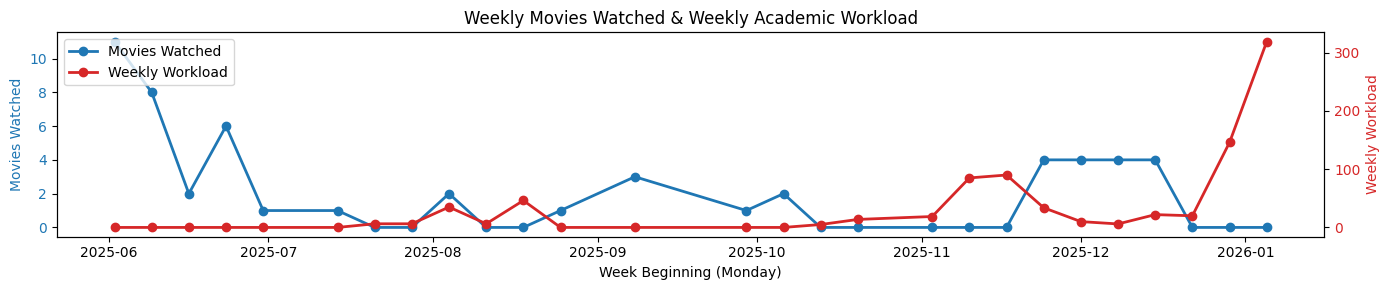

In [24]:
df_watched["MyWatchedDate"] = pd.to_datetime(df_watched["MyWatchedDate"])
df_academic["Date"] = pd.to_datetime(df_academic["Date"], dayfirst=True)


df_watched["WeekStart"] = df_watched["MyWatchedDate"] - pd.to_timedelta(df_watched["MyWatchedDate"].dt.weekday, unit='D')
df_academic["WeekStart"] = df_academic["Date"] - pd.to_timedelta(df_academic["Date"].dt.weekday, unit='D')


df_weekly_movies = (
    df_watched.groupby("WeekStart")["Title"]
    .count()
    .reset_index()
    .sort_values("WeekStart")
)
df_weekly_movies.columns = ["WeekStart", "MoviesWatched"]


df_weekly_workload = (
    df_academic.groupby("WeekStart")["Importancy"]
    .sum()
    .reset_index()
    .sort_values("WeekStart")
)
df_weekly_workload.columns = ["WeekStart", "WeeklyWorkload"]


df_weekly = pd.merge(df_weekly_movies, df_weekly_workload, on="WeekStart", how="outer").fillna(0)


plt.figure(figsize=(14,3))

ax1 = plt.gca()


ax1.plot(df_weekly["WeekStart"], df_weekly["MoviesWatched"],
         marker="o", color="tab:blue", linewidth=2, label="Movies Watched")
ax1.set_xlabel("Week Beginning (Monday)")
ax1.set_ylabel("Movies Watched", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")


ax2 = ax1.twinx()
ax2.plot(df_weekly["WeekStart"], df_weekly["WeeklyWorkload"],
         marker="o", color="tab:red", linewidth=2, label="Weekly Workload")
ax2.set_ylabel("Weekly Workload", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")


lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.xticks(rotation=45)
plt.title("Weekly Movies Watched & Weekly Academic Workload")
plt.tight_layout()
plt.show()


In [25]:
from scipy.stats import ttest_ind
median_w = df_weekly["WeeklyWorkload"].median()

high = df_weekly[df_weekly["WeeklyWorkload"] >= median_w]["MoviesWatched"]
low  = df_weekly[df_weekly["WeeklyWorkload"]  < median_w]["MoviesWatched"]

tstat, p = ttest_ind(high, low, equal_var=False)

print("High workload movie mean:", high.mean())
print("Low workload movie mean:", low.mean())
print("t-stat:", tstat)
print("p-value:", p)

High workload movie mean: 0.9333333333333333
Low workload movie mean: 3.3333333333333335
t-stat: -2.2578886715604476
p-value: 0.03899154533416262


In [26]:
df_weekly_workload = df_academic.groupby("WeekStart")["Importancy"].sum().reset_index()
df_weekly_workload.columns = ["WeekStart", "WeeklyWorkload"]

df_merge = df_watched.merge(df_weekly_workload, on="WeekStart", how="left")

median_w = df_merge["WeeklyWorkload"].median()
df_merge["WorkloadLevel"] = df_merge["WeeklyWorkload"].apply(
    lambda x: "High" if x >= median_w else "Low"
)

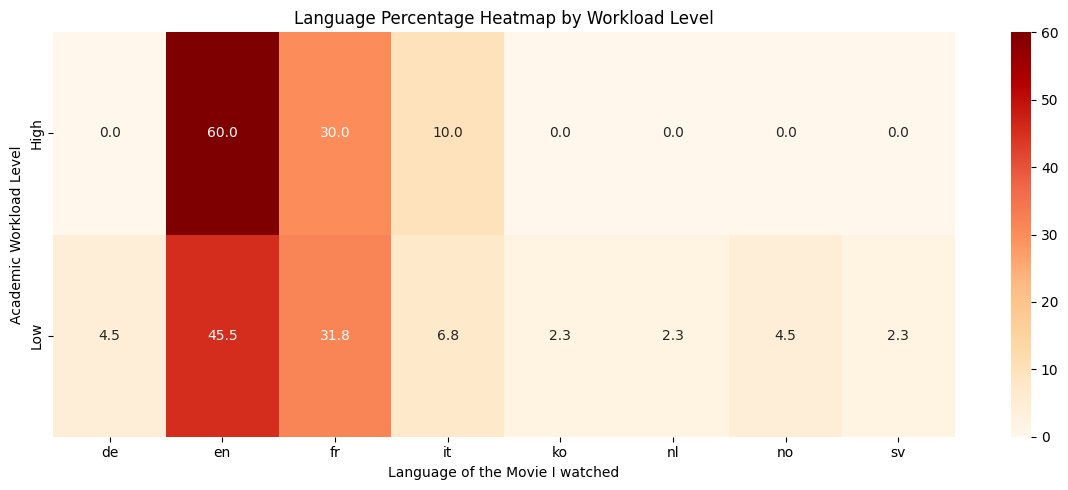

In [27]:

table_lang = pd.crosstab(df_merge["WorkloadLevel"], df_merge["Language"])

percentage_lang = table_lang.div(table_lang.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12,5))
sns.heatmap(percentage_lang, annot=True, fmt=".1f", cmap="OrRd")
plt.title("Language Percentage Heatmap by Workload Level")
plt.xlabel("Language of the Movie I watched")
plt.ylabel("Academic Workload Level")
plt.tight_layout()
plt.show()


In [28]:
from scipy.stats import chi2_contingency
print("Language Contingency Table:")
print(table_lang)

chi2, p, dof, expected = chi2_contingency(table_lang)

print("\nChi-square Statistic:", chi2)
print("p-value:", p)
print("Degrees of Freedom:", dof)

print("\nExpected Frequencies:")
print(expected)

Language Contingency Table:
Language       de  en  fr  it  ko  nl  no  sv
WorkloadLevel                                
High            0   6   3   1   0   0   0   0
Low             2  20  14   3   1   1   2   1

Chi-square Statistic: 2.068870835047306
p-value: 0.9559302887623313
Degrees of Freedom: 7

Expected Frequencies:
[[ 0.37037037  4.81481481  3.14814815  0.74074074  0.18518519  0.18518519
   0.37037037  0.18518519]
 [ 1.62962963 21.18518519 13.85185185  3.25925926  0.81481481  0.81481481
   1.62962963  0.81481481]]


In [ ]:
def clean_genre(g):
    g = str(g).lower()

    if "romance" in g:
        return "Romance"
    if "drama" in g:
        return "Drama"
    if "comedy" in g:
        return "Comedy"
    if "horror" in g:
        return "Horror"
    if "thriller" in g:
        return "Thriller"
    if "mystery" in g:
        return "Mystery"
    if "crime" in g:
        return "Crime"
    if "fantasy" in g:
        return "Fantasy"
    if "science fiction" in g or "sci-fi" in g:
        return "Science Fiction"
    if "action" in g:
        return "Action"
    if "animation" in g:
        return "Animation"
    if "adventure" in g:
        return "Adventure"

    return g.split(",")[0].strip().title()

df_merge["CleanGenre"] = df_merge["Genres"].apply(clean_genre)


In [30]:
table_genre = pd.crosstab(df_merge["WorkloadLevel"], df_merge["CleanGenre"])

chi2, p, dof, expected = chi2_contingency(table_genre)

print(table_genre)
print("Chi2:", chi2)
print("p-value:", p)


CleanGenre        Comedy  Crime  Drama  Horror  Romance  Thriller
WorkloadLevel                                                    
High           0       0      1      7       0        2         0
Low            1       2      0     16       3       21         1
Chi2: 9.626086956521737
p-value: 0.14130730554505316


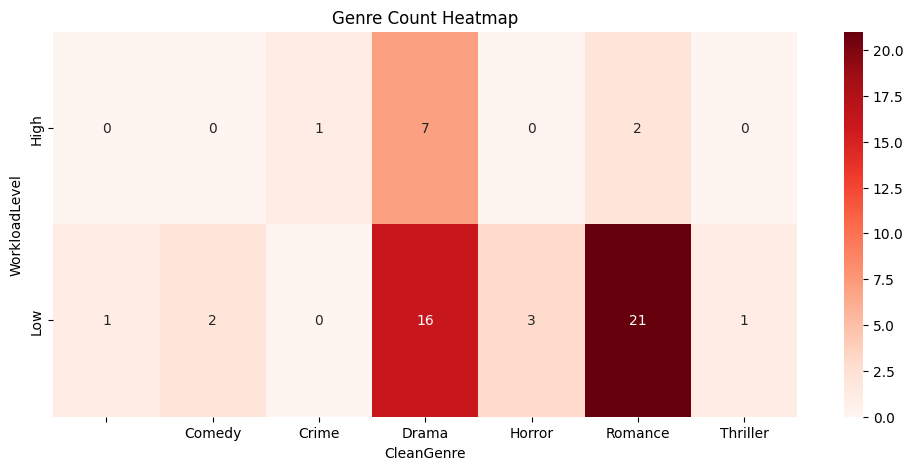

In [31]:
plt.figure(figsize=(12,5))
sns.heatmap(table_genre, annot=True, fmt="d", cmap="Reds")
plt.title("Genre Count Heatmap")
plt.show()


### **MACHINE LEARNING**

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score


In [33]:
df_movies["Watched Date"] = pd.to_datetime(df_movies["Watched Date"])
df_movies["Week"] = df_movies["Watched Date"].dt.to_period("W").apply(lambda r: r.start_time)

weekly_movies = df_movies.groupby("Week").size().reset_index(name="movies_watched")

df_academic["Date"] = pd.to_datetime(df_academic["Date"])
df_academic["Week"] = df_academic["Date"].dt.to_period("W").apply(lambda r: r.start_time)

weekly_workload = (
    df_academic.groupby("Week")["Importancy"]
    .sum()
    .reset_index(name="weekly_workload")
)

ml_df = pd.merge(weekly_movies, weekly_workload, on="Week", how="outer")
ml_df["movies_watched"] = ml_df["movies_watched"].fillna(0)
ml_df["weekly_workload"] = ml_df["weekly_workload"].fillna(0)
ml_df = ml_df.sort_values("Week").reset_index(drop=True)

ml_df.head()


,Week,movies_watched,weekly_workload
0,2024-01-29,1.0,0.0
1,2024-02-05,2.0,0.0
2,2024-03-04,2.0,0.0
3,2024-05-13,1.0,0.0
4,2025-01-06,1.0,0.0


In [34]:
X = ml_df[["weekly_workload"]]
y = ml_df["movies_watched"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=501
)
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
y_pred = reg_model.predict(X_test)



In [35]:
from sklearn.metrics import mean_absolute_error, r2_score

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))


MAE: 2.3640890064247033
R2: -0.17148658418603535


In [36]:
beta_0 = reg_model.intercept_
beta_1 = reg_model.coef_[0]

print(f"Intercept (β₀): {beta_0:.3f}")
print(f"Workload Coefficient (β₁): {beta_1:.3f}")


Intercept (β₀): 1.959
Workload Coefficient (β₁): -0.009


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

workload_range = np.linspace(
    ml_df["weekly_workload"].min(),
    ml_df["weekly_workload"].max(),
    100
).reshape(-1, 1)


In [ ]:
predicted_movies = reg_model.predict(workload_range)

# Negatif tahminleri 0'a çek (mantıklı olması için)
predicted_movies = np.maximum(0, predicted_movies)
